The policy of generic prescribing is frequently cited as a policy that has saved the NHS significant amount of money. One [estimate] puts a figure of £7.1billion of savings over the last 40 years. Here we seek to identify missed savings over the last few years. 

At OpenPrescribing our [PPU tool](https://openprescribing.net/all-england/price-per-unit/) identifies the wide variation in the unit cost of a number of medicines prescribed across England estimates what could be saved if every organisation were prescribing as well as the best 10%. We will seek to isolate the brand -> generic savings only

### Library Imports

In [1]:
import pandas as pd
import numpy as np
from ebmdatalab import bq, maps, charts

In [2]:
## ensuring the format is consistent for pounds and pence
pd.set_option('display.float_format', lambda x: '%.2f' % x)

### Data Imports

In [3]:
sql = '''WITH generic_ppus AS (
  SELECT
    presentation.bnf_code,
    presentation.name,
    vw__median_price_per_unit.date,
    vw__median_price_per_unit.median_price_per_unit
  FROM
    measures.vw__median_price_per_unit
  INNER JOIN
    hscic.presentation
  ON
    vw__median_price_per_unit.bnf_code = presentation.bnf_code
  INNER JOIN
    dmd.vmpp
  ON vmpp.bnf_code = presentation.bnf_code
  INNER JOIN dmd.dtinfo
  ON vmpp.id = dtinfo.vmpp
  WHERE
    substr(presentation.bnf_code, 10, 2) = 'AA' -- generic
   AND dtinfo.pay_cat IN (1,3,11)),

branded_prescribing AS (
  SELECT
    *,
    CONCAT(SUBSTR(bnf_code, 1, 9), 'AA', SUBSTR(bnf_code, 12, 4)) AS generic_bnf_code
  FROM
    hscic.normalised_prescribing_standard
  WHERE
    substr(bnf_code, 10, 2) != 'AA' -- not generic
  )


SELECT
  CAST(generic_ppus.date AS date) AS date,
  generic_ppus.bnf_code,
  pres_stat,
  generic_ppus.name,
  generic_ppus.median_price_per_unit AS target_ppu,
  SUM(branded_prescribing.net_cost) AS cost,
  SUM(branded_prescribing.quantity) AS quantity,
  SUM(branded_prescribing.quantity) * generic_ppus.median_price_per_unit AS target_cost,
  SUM(branded_prescribing.net_cost) - SUM(branded_prescribing.quantity) * generic_ppus.median_price_per_unit AS saving
FROM
  generic_ppus
INNER JOIN
  branded_prescribing
ON
  generic_ppus.bnf_code = branded_prescribing.generic_bnf_code
  AND generic_ppus.date = branded_prescribing.month
INNER JOIN
ebmdatalab.dmd.vmp AS vmp
ON
generic_ppus.bnf_code = vmp.bnf_code
GROUP BY
  generic_ppus.date,
  generic_ppus.bnf_code,
  pres_stat,
  generic_ppus.name,
  target_ppu
ORDER BY
  saving DESC'''

df_generic_saving = bq.cached_read(sql, csv_path='generic_saving.csv', use_cache=True)
df_generic_saving['date'] = df_generic_saving['date'].astype('datetime64[ns]')
df_generic_saving.head()

,date,bnf_code,pres_stat,name,target_ppu,cost,quantity,target_cost,saving
0,2017-01-08,0408010AEAAACAC,1,Pregabalin_Cap 75mg,0.25,1155933.06,1653845,413461.25,742471.81
1,2016-01-09,0301020S0AAAAAA,1,Glycopyrronium Brom_Inh Cap 55mcg + Dev,0.92,692256.94,25173,23075.25,669181.69
2,2016-01-08,0301020S0AAAAAA,1,Glycopyrronium Brom_Inh Cap 55mcg + Dev,0.92,674547.50,24529,22484.92,652062.58
3,2011-01-07,0803041B0AAAAAA,1,Anastrozole_Tab 1mg,0.28,714975.61,306619,86072.33,628903.28
4,2017-01-09,0408010AEAAACAC,1,Pregabalin_Cap 75mg,0.14,796632.82,1214346,168080.91,628551.91


### Analysis

In [4]:
df_generic_saving.sum()

pres_stat          165074.00
target_ppu        1570361.70
cost           6345468237.19
quantity      12724357373.00
target_cost    6060642891.04
saving          284825346.17
dtype: float64

In [5]:
df_2019 = df_generic_saving.loc[(df_generic_saving["date"] >="2019-01-01")] 


In [6]:
df_2019.sum()

pres_stat          9164.00
target_ppu        83906.18
cost          373365660.71
quantity      605301743.00
target_cost   345134072.58
saving         28231588.13
dtype: float64

In [7]:
df_generic_saving_2019 =  df_2019.loc[(df_generic_saving["pres_stat"] == 1)] ## we restrict to products that should only be prescribed as a VMP e.g. exlcude branded prescribing for narrow TI meds


In [8]:
df_generic_saving_2019.sum()

pres_stat          6896.00
target_ppu        79828.28
cost          275042266.01
quantity      584519973.00
target_cost   244248724.05
saving         30793541.96
dtype: float64

The saving is approx £30million in first 6 months of 2019

In [9]:
df_latest_twelve_months = df_generic_saving.loc[(df_generic_saving["date"]>="2018-08-01") & (df_generic_saving["date"]<="2019-07-01")]
df_latest_twelve_months.head()

,date,bnf_code,pres_stat,name,target_ppu,cost,quantity,target_cost,saving
24,2019-01-05,0408010A0AAABAB,1,Levetiracetam_Tab 500mg,0.09,562747.74,684609,60480.93,502266.81
26,2019-01-01,0408010A0AAABAB,1,Levetiracetam_Tab 500mg,0.08,554856.73,675009,53658.55,501198.18
47,2019-01-03,0408010A0AAABAB,1,Levetiracetam_Tab 500mg,0.08,531167.73,646190,51367.06,479800.67
70,2019-01-04,0408010A0AAABAB,1,Levetiracetam_Tab 500mg,0.09,520881.87,633677,55980.94,464900.93
77,2019-01-06,0408010A0AAABAB,1,Levetiracetam_Tab 500mg,0.09,512797.66,623842,55112.79,457684.87


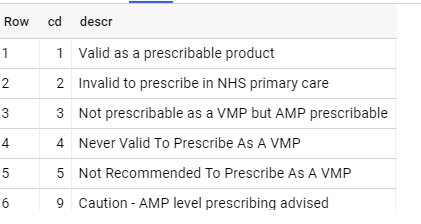

In [10]:
top_savings = df_latest_twelve_months.groupby('name').sum().sort_values(by = 'saving', ascending = False)
top_savings = top_savings.drop(columns =["pres_stat", "target_ppu"]).reset_index()
top_savings.head(100)

,name,cost,quantity,target_cost,saving
0,Levetiracetam_Tab 500mg,3173033.31,3860142,324042.58,2848990.73
1,Levetiracetam_Tab 1g,2522496.97,1587477,221037.99,2301458.98
2,Desogestrel_Tab 75mcg,3588996.64,62281606,1774132.06,1814864.58
3,Tadalafil_Tab 20mg,1117706.54,154807,76485.00,1041221.54
4,Levetiracetam_Tab 250mg,1008696.55,2160682,116307.58,892388.97
5,Macrogol_Co Oral Pdr Sach S/F,2104013.19,9909073,1348598.95,755414.24
6,Mesalazine_Tab E/C 400mg,7507089.64,22972818,6753926.59,753163.05
7,Mycophenolate Mofetil_Tab 500mg,693960.23,421812,48081.87,645878.36
8,Omeprazole_Cap E/C 20mg,659956.81,1106504,31813.59,628143.22
9,Esomeprazole_Tab E/C 20mg,680742.21,1030306,78012.35,602729.86


In [11]:
top_savings.to_csv("last year saving.csv")

PermissionError: [Errno 13] Permission denied: 'last year saving.csv'